## Predicting Pulsars: Mean, Standard Deviation and Kurtosis Analysis

**Logan Chan, Sam Donato, Navneet Bedi, Ahadjon Sultonov**

### Introduction

Pulsars were first discovered in 1967 by astronomers Jocelyn Bell Burnell and Antony Hewish (American Physical Society, 2006). 

A pulsar is a rotating neutron star that is highly magnetized, causing them to emit beams of radiation. These stars provided the first indirect evidence for the existence of gravitational waves. Pulsar stars also have the potential to reveal extreme phenomena in neutron star astrophysics (Zhang et al., 2020. 

Thus, in effect, pulsars can be thought of as 'cosmic lighthouses.'

These beams can appear to pulse as the star rotates, but other astronomical phenomena in space can mimic these pulsar signals, which we call spurious signals. The spurious signals can be challenging to identify and seperate from pulsar signals (Gaskill, 2020). 

The goal of this project will be to use variables from the HTRU2 UC Irvine Machine Learning Repository Pulsar Star Dataset to classify whether a star is pulsar or not.

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South). The data set shared contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples (Lyon, 2017).  In the data set, legitimate pulsar examples are a minority positive class, and spurious examples are the majority negative class. The class labels used are 0 (negative) and 1 (positive). Due to the number of predictor variables, we only chose a few potentially important predictors to focus on for the preliminary analysis.

The question we will be addressing is as follows: **Given the mean, standard deviation, and excess kurtosis of the integrated profile, can we predict if a star is pulsar or if it is a spurious signal?** 
To answer this question, we will be using the knn classifier algorithm.

### Preliminary Data Analysis and Methods

We are using the HTRU_2.csv data from the UC Irvine Machine Learning Repository Pulsar Star Dataset to predict if a star is a pulsar or a spurious signal. The columns we are using to predict our unknown are as follows:

1. **mean_ip**: Mean of the integrated profile,
2. **std_dev_ip**: Standard deviation of the integrated profile,
4. **kurtosis_ip**: Excess kurtosis of the integrated profile,
5. **type**: Type of a star ( 0 = **spurious signal**, 1 = **pulsar**)

In [1]:
## Load libraries
library(tidyverse)
library(repr)
library(tidymodels)

set.seed(18)

## Download dataset from the internet
url <- "https://raw.githubusercontent.com/loganchan26/DSCI-100-project-group10-18/03a96760928865bfb961dc8ea308d3b129a82baf/HTRU_2.csv"
download.file(url, "data/pulsar_data.csv")
pulsar_data <- read_csv("data/pulsar_data.csv")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

There are 17,897 rows with no missing data.

In [63]:
## rename columns and select columns of interest (convert type into pulsar/spurious?)
colnames(pulsar_data) <- c("mean_ip", "std_dev_ip", "kurtosis_ip", "skew_ip", "mean_curve", "std_dev_curve", "kurtosis_curve", "skew_curve", "type") 
pulsar_data_selected <- pulsar_data |> select("mean_ip", "std_dev_ip", "kurtosis_ip", "type")
#glimpse(pulsar_data_selected)

There are 17,897 rows with no missing data. 
To clean the data, we assigned names to each of the initial 9 columns by using the `colnames()` function. Next, we selected the `mean_ip`, `std_dev_ip` `kurtosis_ip`, and `type` columns that we will be using for data analysis. 

In [64]:
## split set into training and testing
pulsar_split <- initial_split(pulsar_data_selected, prop = 0.75, strata = type)
pulsar_training <- training(pulsar_split)
pulsar_testing  <- testing(pulsar_split)

To classify whether a star is a pulsar or spurious signal, we will be using the K-nearest neighbors classification algorithm. We used `initial_split()` to split our data frame into 75% training and 25% testing data, stratifying for `type`. We will only use the training set for analysis.

In [65]:
##summarize data into table(s) - mean values of each variable, number of each observation
mean_vars <- pulsar_training |>
            mutate(avg_mean_ip = mean(mean_ip)) |>
            mutate(avg_std_dev_ip = mean(std_dev_ip)) |>
            mutate(avg_kurtosis_ip = mean(kurtosis_ip)) |>
            select("avg_mean_ip", "avg_std_dev_ip", "avg_kurtosis_ip") |>
            slice(1)
mean_vars

#number of each observation
num_observations <- pulsar_training |>
                    group_by(type) |>
                    summarize(count = n())
num_observations

avg_mean_ip,avg_std_dev_ip,avg_kurtosis_ip
<dbl>,<dbl>,<dbl>
110.9673,46.54693,0.4791708


type,count
<dbl>,<int>
0,12205
1,1217


**Tables** to visualize the number of observations of each type (type 0 = RFI/noise, type 1 = pulsar star) and the average values of each variable (mean of integrated profile, standard deviation of integrated profile, and excess kurtosis of the integrated profile). 

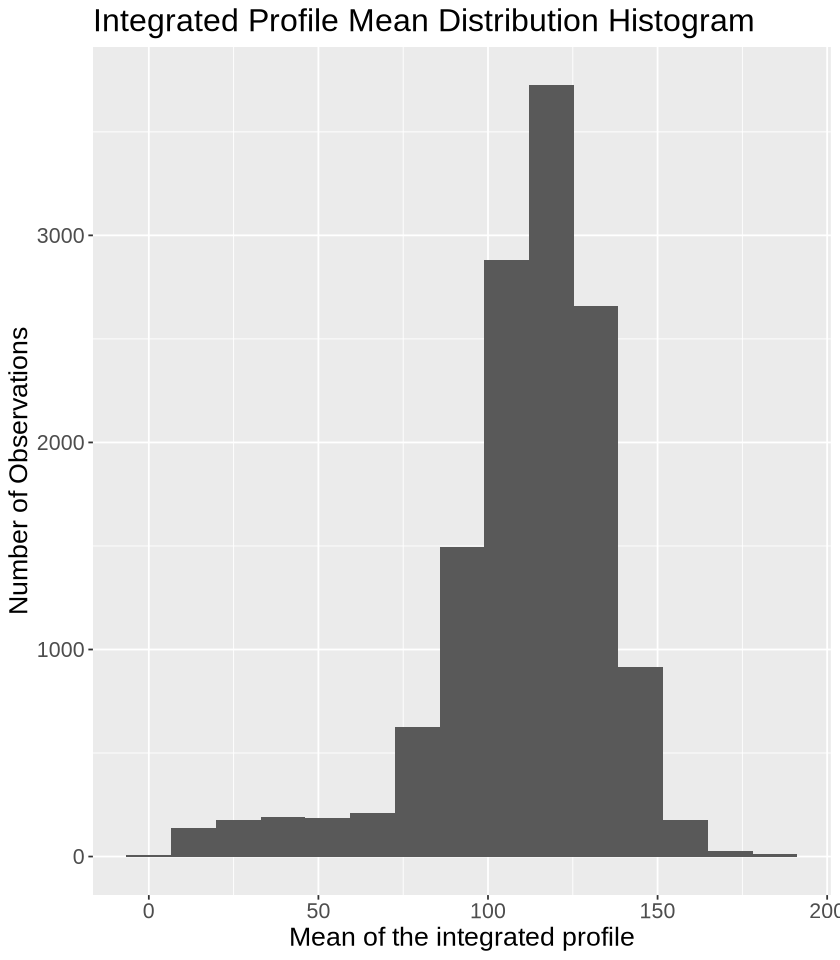

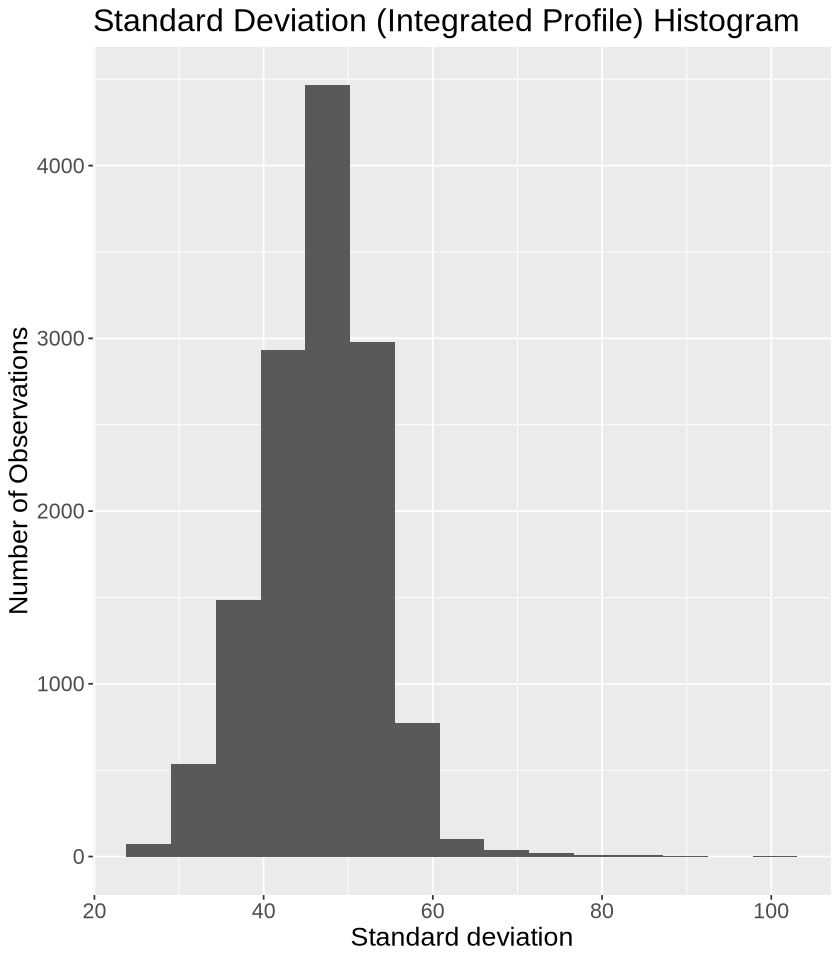

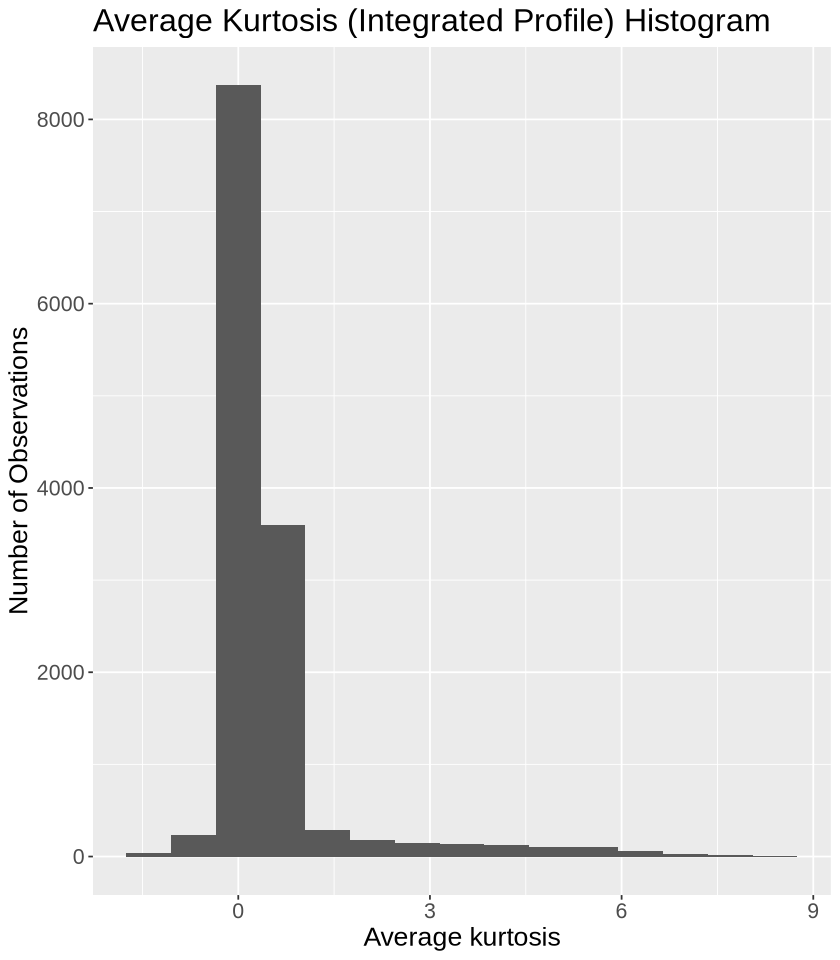

In [66]:
## visualize data into scatterplot - distribution of each variable
options(repr.plot.width = 7, repr.plot.height = 8)

# mean_ip histogram
mean_ip_histogram <- pulsar_training |>
    ggplot(aes(x = mean_ip)) +
        geom_histogram(bins = 15) +
        labs(x = "Mean of the integrated profile", y = "Number of Observations") +
        ggtitle("Integrated Profile Mean Distribution Histogram") +
        theme(text = element_text(size = 16))
mean_ip_histogram

# std_dev histogram
std_dev_histogram <- pulsar_training |>
    ggplot(aes(x = std_dev_ip)) +
        geom_histogram(bins = 15) +
        labs(x = "Standard deviation", y = "Number of Observations") +
        ggtitle("Standard Deviation (Integrated Profile) Histogram") +
        theme(text = element_text(size = 16))
std_dev_histogram

# avg_kurtosis histogram
avg_kurtosis_histogram <- pulsar_training |>
    ggplot(aes(x = kurtosis_ip)) +
        geom_histogram(bins = 15) +
        labs(x = "Average kurtosis", y = "Number of Observations") +
        ggtitle("Average Kurtosis (Integrated Profile) Histogram") +
        theme(text = element_text(size = 16))
avg_kurtosis_histogram

**Histograms** to visualize the distribution of `Standard deviation of the integrated profile`, `Mean of the integrated profile`, and `Excess kurtosis of the integrated profile`.

### Expected outcomes and significance:

We are trying to find which category our unknown star belongs to using classification; a pulsar on a non pulsar star. It can allow us to find what type of star we are looking at and further research can be taken on after categorizing the star. Helps understand the star life since pulsars are remains of massive stars that have exploded. By studying pulsar stars, astronomers can learn more about the evolution of stars and what happens to them after they explode. Since pulsars are super dense and have strong magnetic fields, studying them allows scientists to understand the complexity of the universe. Furthermore, pulsar stars are all across our galaxy. This means that more data on their signals can be used to further determine more interesting interactions between the pulsar stars, the Earth, and the galaxy. Categorizing a star as a pulsar can further give scientists more data which can allow them to further understand the connection between space and time since these stars are accurate at keeping time. This knowledge can also further permit an increase in knowledge of gravity, space waves, and also the discovery of new possible planets. Moreover, it would lead to more theories which would lead to the search for more connection between pulsar stars and their importance in the galaxy.

### Bibliography

Cheng Jun Zhang, Zhen Hong Shang, Wan Min Chen, Liu Xie, Xiang Hua Miao, A Review of Research on Pulsar Candidate Recognition Based on Machine Learning, Procedia Computer Science, Volume 166, 2020, Pages 534-538, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2020.02.050.

Chodos, Alan. (February 2006). American Physical Society. APS News, Volume 15, Number 2). https://www.aps.org/publications/apsnews/200602/history.cfm

Gaskill, Melissa. (June 22, 2020). Phys.org https://phys.org/news/2020-06-future-space-cosmic-lighthouses.html 


Lyon, Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R